**Modelo de red neuronal ELM**

Este archivo consta de los codigos y conclusiones de:
* 1.Carga de librerias y datos
* 2.Normalizar Datos.
* 3.Preparar datos para realizar aprendizaje supervizado.
* 4.Modelo ELM
* 5.Evaluacion del modelo


#1.Carga de Librerias y Datos


*Se importan los módulos necesarios para trabajar*

In [142]:
#Pandas es utilizado para leer los set de datos
import pandas as pd
#Numpy es utilizado para generar las series de datos a graficar
import numpy as np
#Seaborn es utilizado para generar los gráficos
import seaborn as sns
import matplotlib.pyplot as plt
#Se importan modulos estadisticos para generar test de hipotesis, entre otros
from sklearn.preprocessing import StandardScaler
#Módulos implementa funciones que evalúan el error de predicción para propósitos específicos
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
#Ignorar warnings
import warnings
warnings.filterwarnings("ignore")

#Dividir arreglos o matrices en subconjuntos aleatorios de tren y prueba
from sklearn.model_selection import train_test_split

#Biblioteca de Redes Neuronales
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dropout, LSTM, Dense, Activation,Input
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasRegressor

from hyperopt import Trials, STATUS_OK, tpe, hp, fmin, space_eval
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict, TimeSeriesSplit
import time

In [77]:
# Para acceder a los archivos del gdrive
from google.colab import drive
drive.mount('/content/gdrive/')


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [78]:
cd /content/gdrive/MyDrive/Tesis/Datos

/content/gdrive/MyDrive/Tesis/Datos


Se obtiene conjunto de datos

In [79]:
df=pd.read_csv('df.csv')
df=df.drop(['Year', 'Week', 'Day','Month','Size','Type'], axis=1)

In [80]:
df.set_index('Date', inplace=True)


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 380380 entries, 2010-02-05 to 2012-10-26
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         380380 non-null  int64  
 1   Dept          380380 non-null  int64  
 2   Weekly_Sales  380380 non-null  float64
 3   IsHoliday     380380 non-null  bool   
 4   Temperature   380380 non-null  float64
 5   Fuel_Price    380380 non-null  float64
 6   MarkDown1     380380 non-null  float64
 7   MarkDown2     380380 non-null  float64
 8   MarkDown3     380380 non-null  float64
 9   MarkDown4     380380 non-null  float64
 10  MarkDown5     380380 non-null  float64
 11  CPI           380380 non-null  float64
 12  Unemployment  380380 non-null  float64
dtypes: bool(1), float64(10), int64(2)
memory usage: 38.1+ MB


In [82]:
df.shape

(380380, 13)

In [83]:
#Setear semilla
np.random.seed(42)

#2. Obtener series de Tiempo

*Se obtiene lista de dataframe ordenados por Store y Dept*

In [84]:
series_time=[]
lista_Store=df.Store.unique()
lista_Store.sort()
lista_dept=df.Dept.unique()
lista_dept.sort()

for i in lista_Store:
  for j in lista_dept:
    #lista=[]
    test=df[(df.Store==i) & (df.Dept==j)]
    if(test.empty!=True):
        series_time.append(test)

In [85]:
len(series_time)

2660

#3.Normalizar base de datos

El **método de puntuación z** (a menudo llamado estandarización ) transforma los datos en una distribución con una media de 0 y una desviación estándar de 1 . Cada valor estandarizado se calcula restando la media de la característica correspondiente y luego dividiendo por la desviación estándar.

In [86]:
#Seleccion de caracteristicas
features =features = [feature for feature in df.columns if feature not in ('Store','Dept')]

#Se define escalado
std_scaler = StandardScaler()

series_time_scaled=[]

#Transformacion
for serie in series_time:
  for i in features:
    serie[i]=std_scaler.fit_transform(serie[i].values.reshape(-1,1))
  series_time_scaled.append(serie)

for i in features:
  df[i] = std_scaler.fit_transform(df[i].values.reshape(-1,1))

series_time_scaled[0]

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
Date,,,,,,,,,,,,,
2010-02-05,1,1,0.245542,-0.274204,-1.830686,-1.521079,-0.524358,-0.193456,-0.092151,-0.336050,-0.579339,-1.130288,1.295958
2010-02-12,1,1,2.395781,3.646917,-2.098280,-1.577441,-0.524358,-0.193456,-0.092151,-0.336050,-0.579339,-1.096657,1.295958
2010-02-19,1,1,1.943233,-0.274204,-1.998285,-1.657288,-0.524358,-0.193456,-0.092151,-0.336050,-0.579339,-1.085823,1.295958
2010-02-26,1,1,-0.316684,-0.274204,-1.526473,-1.546911,-0.524358,-0.193456,-0.092151,-0.336050,-0.579339,-1.078788,1.295958
2010-03-05,1,1,-0.069800,-0.274204,-1.535627,-1.396612,-0.524358,-0.193456,-0.092151,-0.336050,-0.579339,-1.071754,1.295958
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-09-28,1,1,-0.363093,-0.274204,0.547388,1.048107,0.141879,-0.191745,-0.091796,0.020611,0.956274,1.611008,-1.836849
2012-10-05,1,1,-0.062002,-0.274204,0.017127,0.933034,0.943562,-0.193456,-0.088232,0.573847,0.594358,1.657095,-2.712884
2012-10-12,1,1,0.025529,-0.274204,-0.374406,0.895459,-0.145256,-0.193456,-0.090407,-0.184537,1.338915,1.703183,-2.712884


In [87]:
len(series_time_scaled)

2660

In [88]:
import random
series_time_scaled=random.sample(series_time_scaled,20)

#4.Preparar datos para realizar aprendizaje supervizado.

La idea es modelar cada valor en función de los valores recientes anteriores, dado un retardo de tiempo dado. **Los valores futuros de una variable en una serie de tiempo dependen de sus propios rezagos y de los rezagos de otras variables.**

In [89]:
def time_delay_embedding(series: pd.Series, n_lags: int, horizon: int):
    """
    Incrustación de retardo de tiempo
    :param series: serie de tiempo como objeto de pandas
    :param n_lags: número de valores pasados para usar como variables explicativas
    :param horizon: horizonte de pronostico
    :return:pd.DataFrame con series temporales reconstruidas
    """
    assert isinstance(series, pd.Series)

    if series.name is None:
        name = 'Series'
    else:
        name = series.name

    n_lags_iter = list(range(n_lags, -horizon, -1))

    serie_time_delay = [series.shift(i) for i in n_lags_iter]
    serie_time_delay = pd.concat(serie_time_delay, axis=1).dropna()
    serie_time_delay.columns = [f'{name}(t-{j - 1})'
                 if j > 0 else f'{name}(t+{np.abs(j) + 1})'
                 for j in n_lags_iter]

    return serie_time_delay

In [90]:
series_predic=[]
series_target=[]
for serie in series_time_scaled:
  serie_split = []
  for columna in serie:
    col_df = time_delay_embedding(
        serie[columna],     #Serie de tiempo
        n_lags=1,           #Numero de retrasos
        horizon=1           # Horizonte de prediccion
          )
    serie_split.append(col_df)

  serie_df = pd.concat(serie_split, axis=1).dropna()
  predictor_variables = serie_df.columns.str.contains('\(t\-')
  target_variables = serie_df.columns.str.contains('Weekly_Sales\(t\+')

  predictor_variables = serie_df.iloc[:, predictor_variables]
  target_variables = serie_df.iloc[:, target_variables]
  series_predic.append(predictor_variables)
  series_target.append(target_variables)

In [91]:
#Ejemplo de variables de prediccion de una serie
series_predic[0].head()

,Store(t-0),Dept(t-0),Weekly_Sales(t-0),IsHoliday(t-0),Temperature(t-0),Fuel_Price(t-0),MarkDown1(t-0),MarkDown2(t-0),MarkDown3(t-0),MarkDown4(t-0),MarkDown5(t-0),CPI(t-0),Unemployment(t-0)
Date,,,,,,,,,,,,,
2010-02-12,16.0,27.0,-0.817809,-0.274204,-1.516764,-1.543841,-0.398645,-0.218446,-0.090597,-0.346339,-0.593399,-1.341409,1.592021
2010-02-19,16.0,27.0,-0.102000,3.646917,-1.451863,-1.562510,-0.398645,-0.218446,-0.090597,-0.346339,-0.593399,-1.315544,1.592021
2010-02-26,16.0,27.0,-0.520490,-0.274204,-1.436239,-1.613850,-0.398645,-0.218446,-0.090597,-0.346339,-0.593399,-1.293672,1.592021
2010-03-05,16.0,27.0,-0.766199,-0.274204,-1.617120,-1.529839,-0.398645,-0.218446,-0.090597,-0.346339,-0.593399,-1.272466,1.592021
2010-03-12,16.0,27.0,-0.835760,-0.274204,-1.028204,-1.450495,-0.398645,-0.218446,-0.090597,-0.346339,-0.593399,-1.251260,1.592021


In [92]:
#Ejemplo de variables objetivo de una serie
series_target[0].head()

,Weekly_Sales(t+1)
Date,
2010-02-12,-0.102000
2010-02-19,-0.520490
2010-02-26,-0.766199
2010-03-05,-0.835760
2010-03-12,-0.898590


In [93]:
#Se separa conjunto en entrenamiento y prueba; sin aleatoriedad
#Dejando un %20 de la data para test
X_train=pd.DataFrame()
X_test=pd.DataFrame()
Y_train=pd.DataFrame()
Y_test=pd.DataFrame()

for serie,target in zip(series_predic,series_target):
  X_train_i, X_test_i, Y_train_i, Y_test_i = train_test_split(serie, target, test_size=0.2, shuffle=False)
  X_train=pd.concat([X_train, X_train_i])
  X_test=pd.concat([X_test, X_test_i])
  Y_train=pd.concat([Y_train, Y_train_i])
  Y_test=pd.concat([Y_test, Y_test_i])


shape=len(X_train.columns)

print("Separacion de datos terminada!")

Separacion de datos terminada!


#ELM

In [94]:
X_train_a=X_train.to_numpy()
Y_train_a=Y_train.to_numpy()
X_test_a=X_test.to_numpy()
Y_test_a=Y_test.to_numpy()

In [95]:
print(X_train_a.shape)
print(Y_train_a.shape)
print(X_test_a.shape)
print(Y_test_a.shape)

(2260, 13)
(2260, 1)
(580, 13)
(580, 1)


In [96]:
pip install hpelm --quiet

In [97]:
from hpelm import ELM
from sklearn.model_selection import cross_val_score, KFold
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [98]:
 # Definir la función objetivo
def objective(params):
    n_neurons = int(params['neurons'])
    activation = params['activation']



    #kf = KFold(n_splits=5)
    tscv = TimeSeriesSplit(n_splits=5)
    scores_mse = []
    scores_rmse = []
    scores_mae= []
    scores_mape= []
    times=[]
    models=[]
    #Validacion cruzada
    for train_index, test_index in tscv.split(X_train_a):
      X_train_, X_test_ = X_train_a[train_index], X_train_a[test_index]
      y_train_, y_test_ = Y_train_a[train_index], Y_train_a[test_index]

      # Crear un objeto ELM
      model =ELM(X_train_a.shape[1], 1)

      # Añadir una capa oculta con los hiperparámetros
      model.add_neurons(n_neurons, activation)

      #Entrenamiento
      start = time.time()
      model.train(X_train_, y_train_)
      end = time.time()

      #Evaluacion del modelo
      y_pred = model.predict(X_test_a)
      score_mse = mse(Y_test_a, y_pred)
      rmse = np.sqrt(score_mse)  # Calcular el RMSE
      score_mae = mae(Y_test_a, y_pred)
      score_mape= mape(Y_test_a, y_pred)


      scores_mse.append(score_mse)
      scores_mae.append(score_mae)
      scores_mape.append(score_mape)
      scores_rmse.append(rmse)

      models.append(model)

      #Tiempo de la validadion cruzada
      time_val= end- start
      times.append(time_val)

    return {'loss': np.mean(score_mse),
            'status': STATUS_OK,
            'model': model,
            'params': params,
            'time':times,
            'predic':y_pred,
            'scores_mse': scores_mse,
            'scores_mae': scores_mae,
            'scores_mape': scores_mape,
            'scores_rmse': scores_rmse,
            'models':models
            }

In [99]:
# Definir el espacio de búsqueda de hiperparámetros
space = {
    'neurons': hp.quniform('neurons', 32, 512, 32),
    'activation': hp.choice('activation', ['sigm', 'tanh']),
}

In [100]:
# Optimización bayesiana
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

print("Los mejores hiperparámetros son: ", best)

# Los resultados completos (incluyendo los scores de validación cruzada para cada evaluación) están en el objeto 'trials'

Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not

In [101]:
# Obtener una lista de los resultados de todas las evaluaciones
all_results = [trial['result'] for trial in trials]

#Exportar resultados

In [154]:
#Del objeto all_results donde estan los resultados de cada trial de la optimizacion bayesiana se obtiene los parametros para exportalos a un csv
results=[]
trial=0 #Nº de intento de optimizacion bayesiana

for result in all_results:
  k=0 #validacion cruzada
  trial+=1
  for time,score_mse,score_mae,score_mape,score_rmse in zip(result['time'],result['scores_mse'],result['scores_rmse'],result['scores_mae'],result['scores_mape']):
    k+=1
    nameModel = "ELM" + "_"+str(result['params']['activation'])+"_"+str(result['params']['neurons'])
    results.append([nameModel,trial,k,time,score_mse,score_rmse,score_mae,score_mape])

In [153]:
#Se crea dataframe
results_csv=pd.DataFrame(results,columns=['nameModel','trial_optimizacion_bayesiana','Step_validacion','time','MSE','RMSE','MAE','MAPE'])

results_o = results_csv.sort_values(by='MSE', ascending=True)
results_o.head(5)

,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
119,ELM_sigm_64.0,24,5,0.008440,0.759591,4.789837,0.871545,0.651224
109,ELM_sigm_32.0,22,5,0.002949,0.807922,2.430696,0.898845,0.674286
113,ELM_sigm_32.0,23,4,0.002595,0.836543,3.998856,0.914627,0.678753
111,ELM_sigm_32.0,23,2,0.001105,0.874208,2.389447,0.934991,0.720544
92,ELM_tanh_32.0,19,3,0.021940,0.889609,2.369387,0.943191,0.714121


In [157]:
results_csv["time"].mean()

0.03900222682952881

In [105]:
# Exportar el DataFrame como CSV
results_csv.to_csv('results_ELM_wallmart.csv')

In [106]:
best_model=all_results[21]["models"][3]

In [107]:
predic = all_results[21]['predic']

###Grafico de prediccion

In [108]:
def divide_array(array, num_parts):
  i=0
  j=0
  largo=int(len(array)/num_parts)
  j=largo
  series_results=[]

  x=[]
  for k in range(num_parts):
    aux= array[i:j]
    j=largo+j
    i=i+largo
    series_results.append(aux)
    x.append(aux)

  return x

In [109]:
series_result_predict=divide_array(predic,20)
series_result_real=divide_array(Y_test,20)

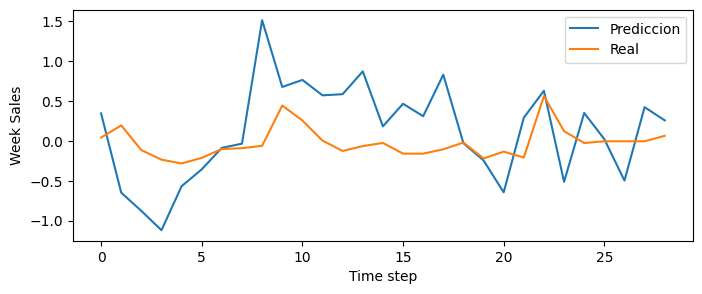

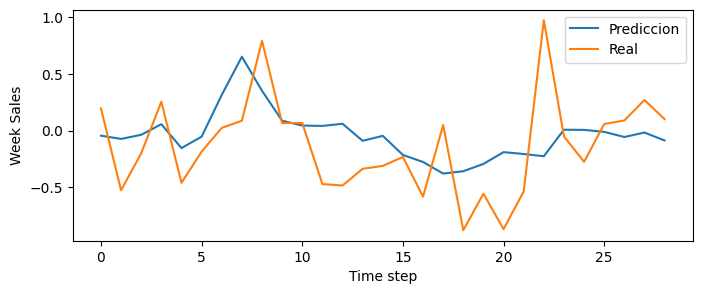

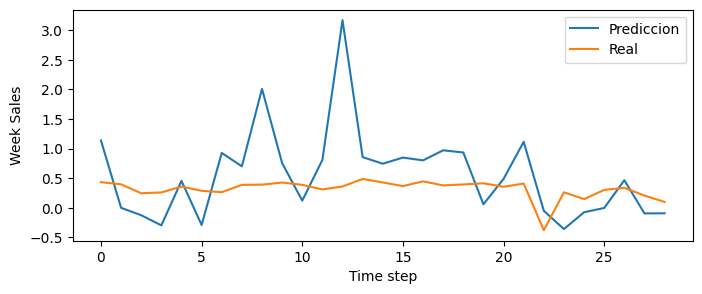

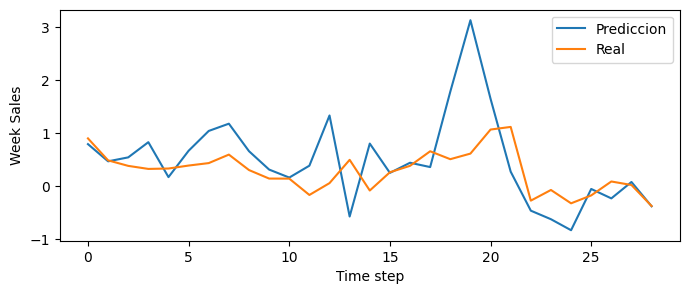

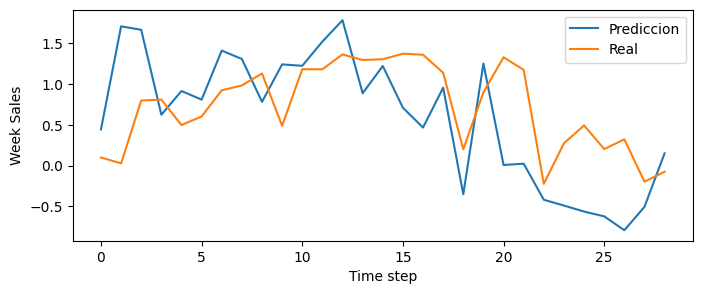

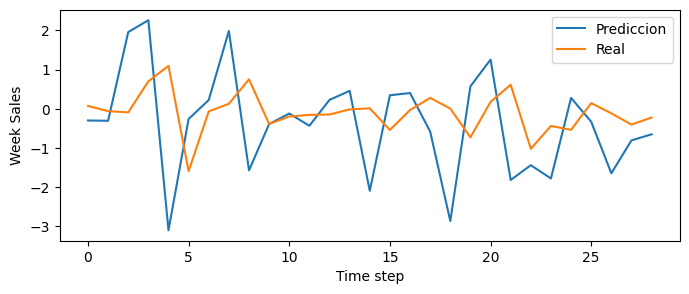

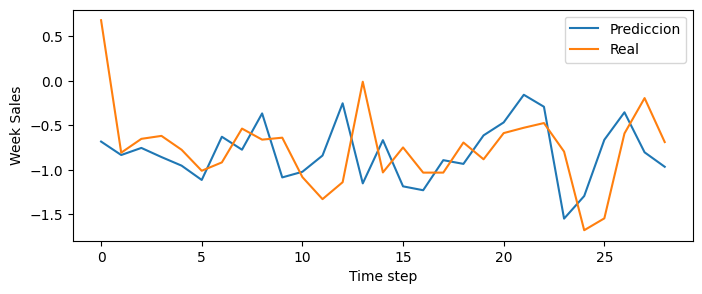

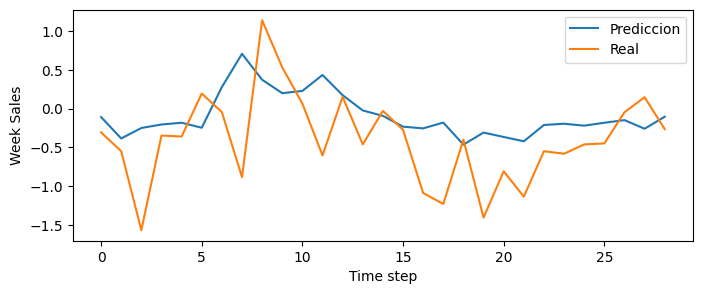

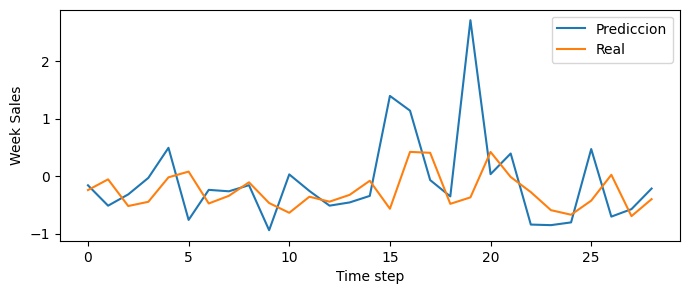

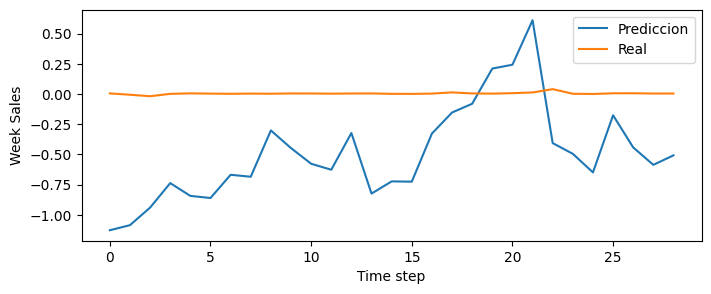

In [110]:
series_result_predict=series_result_predict[0:10]
series_result_real=series_result_real[0:10]
for predict, real in zip(series_result_predict,series_result_real):
  #Grafico de prediccion con el valor real
  tiempo=[x for x in range(predict.shape[0])]
  plt.figure(figsize=(8,3))
  plt.plot(tiempo,real)
  plt.ylabel('Week Sales', size=10)
  plt.plot(tiempo,predict)
  plt.xlabel('Time step', size=10)
  plt.legend(['Prediccion','Real'])
  plt.show()

#NARMAX


In [121]:
predictor_variables=pd.read_csv('predictor_variables.csv', index_col='Date')
target_variables=pd.read_csv('target_variables.csv', index_col='Date')
df=pd.read_csv('df_modelo.csv', index_col='Date')

In [122]:
predictor_variables=predictor_variables.to_numpy()
target_variables=target_variables.to_numpy()

In [123]:
def divide_array(array, num_parts,largo):
  i=0
  j=0
  j=largo
  series_results=[]

  x=[]
  for k in range(20):
    aux= array[i:j]
    j=largo+j
    i=i+largo
    series_results.append(aux)
    x.append(aux)

  return x

In [124]:
series=divide_array(df,20,143)
predict_series=divide_array(predictor_variables,20,142)
target_series=divide_array(target_variables,20,142)

In [125]:
#Se da formato de entradas como: Un tensor 3D con la forma [batch, timesteps, feature]
predictor_variable=[]
target_variable=[]
for serie, target in zip(predict_series,target_series):
  predictor=np.array(serie)
  predictor_variable.append(predictor)
  target=np.array(target)
  target_variable.append(target)

  target_shape=target.shape

In [126]:
def narmax_data(data,modelo,predictor,shape_target,retrasos,target):
  #Se realiza prediccion
  results = modelo.predict(predictor)


  error=[]
  aux=0
  for prediccion, real in zip(results,target):
    aux=real-prediccion
    error.append(aux[0])

  df_narmax = data.iloc[1:]
  # Agregamos el arreglo como nueva columna en el DataFrame
  df_narmax['error'] = error

  return df_narmax

In [127]:
series_time=[]
for serie,predictor,target in zip(series,predict_series,target_series):
  aux=narmax_data(serie,best_model,predictor,target_shape,1,target)
  series_time.append(aux)


In [128]:
series_time[0]

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,error
Date,,,,,,,,,,,,,,
2010-02-12,7,9,-1.066339,3.646917,-0.837239,-1.562510,-0.342316,-0.233833,-0.089166,-0.294143,-0.256216,-1.315544,1.000733,0.116327
2010-02-19,7,9,-1.055308,-0.274204,-0.753638,-1.613850,-0.342316,-0.233833,-0.089166,-0.294143,-0.256216,-1.293672,1.000733,-0.561950
2010-02-26,7,9,-1.026079,-0.274204,-0.897213,-1.529839,-0.342316,-0.233833,-0.089166,-0.294143,-0.256216,-1.272466,1.000733,-0.005801
2010-03-05,7,9,-1.077562,-0.274204,-0.233857,-1.450495,-0.342316,-0.233833,-0.089166,-0.294143,-0.256216,-1.251260,1.000733,-0.084368
2010-03-12,7,9,-1.053027,-0.274204,-0.755455,-1.301142,-0.342316,-0.233833,-0.089166,-0.294143,-0.256216,-1.230053,1.000733,-0.064768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-09-28,7,9,-0.144565,-0.274204,0.661521,1.277528,0.217803,-0.230168,-0.087864,0.147478,0.106075,1.542983,-1.667791,0.280939
2012-10-05,7,9,-0.360016,-0.274204,0.527639,1.254192,0.100890,-0.233833,-0.086302,0.784767,0.011427,1.615590,-2.403855,0.334208
2012-10-12,7,9,-0.115887,-0.274204,0.103576,1.209853,-0.296936,-0.233833,-0.088089,-0.113224,-0.152332,1.688198,-2.403855,0.668438


#4.Preparar datos para realizar aprendizaje supervizado.

La idea es modelar cada valor en función de los valores recientes anteriores, dado un retardo de tiempo dado. **Los valores futuros de una variable en una serie de tiempo dependen de sus propios rezagos y de los rezagos de otras variables.**

In [129]:
def time_delay_embedding(series: pd.Series, n_lags: int, horizon: int):
    """
    Incrustación de retardo de tiempo
    :param series: serie de tiempo como objeto de pandas
    :param n_lags: número de valores pasados para usar como variables explicativas
    :param horizon: horizonte de pronostico
    :return:pd.DataFrame con series temporales reconstruidas
    """
    assert isinstance(series, pd.Series)

    if series.name is None:
        name = 'Series'
    else:
        name = series.name

    n_lags_iter = list(range(n_lags, -horizon, -1))

    serie_time_delay = [series.shift(i) for i in n_lags_iter]
    serie_time_delay = pd.concat(serie_time_delay, axis=1).dropna()
    serie_time_delay.columns = [f'{name}(t-{j - 1})'
                 if j > 0 else f'{name}(t+{np.abs(j) + 1})'
                 for j in n_lags_iter]

    return serie_time_delay

In [130]:
series_predic=[]
series_target=[]
for serie in series_time_scaled:
  serie_split = []
  for columna in serie:
    col_df = time_delay_embedding(
        serie[columna],     #Serie de tiempo
        n_lags=1,           #Numero de retrasos
        horizon=1           # Horizonte de prediccion
          )
    serie_split.append(col_df)

  serie_df = pd.concat(serie_split, axis=1).dropna()
  predictor_variables = serie_df.columns.str.contains('\(t\-')
  target_variables = serie_df.columns.str.contains('Weekly_Sales\(t\+')

  predictor_variables = serie_df.iloc[:, predictor_variables]
  target_variables = serie_df.iloc[:, target_variables]
  series_predic.append(predictor_variables)
  series_target.append(target_variables)

In [131]:
#Ejemplo de variables de prediccion de una serie
series_predic[0].head()

,Store(t-0),Dept(t-0),Weekly_Sales(t-0),IsHoliday(t-0),Temperature(t-0),Fuel_Price(t-0),MarkDown1(t-0),MarkDown2(t-0),MarkDown3(t-0),MarkDown4(t-0),MarkDown5(t-0),CPI(t-0),Unemployment(t-0)
Date,,,,,,,,,,,,,
2010-02-12,16.0,27.0,-0.817809,-0.274204,-1.516764,-1.543841,-0.398645,-0.218446,-0.090597,-0.346339,-0.593399,-1.341409,1.592021
2010-02-19,16.0,27.0,-0.102000,3.646917,-1.451863,-1.562510,-0.398645,-0.218446,-0.090597,-0.346339,-0.593399,-1.315544,1.592021
2010-02-26,16.0,27.0,-0.520490,-0.274204,-1.436239,-1.613850,-0.398645,-0.218446,-0.090597,-0.346339,-0.593399,-1.293672,1.592021
2010-03-05,16.0,27.0,-0.766199,-0.274204,-1.617120,-1.529839,-0.398645,-0.218446,-0.090597,-0.346339,-0.593399,-1.272466,1.592021
2010-03-12,16.0,27.0,-0.835760,-0.274204,-1.028204,-1.450495,-0.398645,-0.218446,-0.090597,-0.346339,-0.593399,-1.251260,1.592021


In [132]:
#Ejemplo de variables objetivo de una serie
series_target[0].head()

,Weekly_Sales(t+1)
Date,
2010-02-12,-0.102000
2010-02-19,-0.520490
2010-02-26,-0.766199
2010-03-05,-0.835760
2010-03-12,-0.898590


In [133]:
#Se separa conjunto en entrenamiento y prueba; sin aleatoriedad
#Dejando un %20 de la data para test
X_train=pd.DataFrame()
X_test=pd.DataFrame()
Y_train=pd.DataFrame()
Y_test=pd.DataFrame()

for serie,target in zip(series_predic,series_target):
  X_train_i, X_test_i, Y_train_i, Y_test_i = train_test_split(serie, target, test_size=0.2, shuffle=False)
  X_train=pd.concat([X_train, X_train_i])
  X_test=pd.concat([X_test, X_test_i])
  Y_train=pd.concat([Y_train, Y_train_i])
  Y_test=pd.concat([Y_test, Y_test_i])


shape=len(X_train.columns)

print("Separacion de datos terminada!")

Separacion de datos terminada!


#ELM

In [134]:
X_train_a=X_train.to_numpy()
Y_train_a=Y_train.to_numpy()
X_test_a=X_test.to_numpy()
Y_test_a=Y_test.to_numpy()

In [135]:
print(X_train_a.shape)
print(Y_train_a.shape)
print(X_test_a.shape)
print(Y_test_a.shape)

(2260, 13)
(2260, 1)
(580, 13)
(580, 1)


In [136]:
pip install hpelm --quiet

In [137]:
from hpelm import ELM
from sklearn.model_selection import cross_val_score, KFold
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [138]:
 # Definir la función objetivo
def objective(params):
    n_neurons = int(params['neurons'])
    activation = params['activation']



    #kf = KFold(n_splits=5)
    tscv = TimeSeriesSplit(n_splits=5)
    scores_mse = []
    scores_rmse = []
    scores_mae= []
    scores_mape= []
    times=[]
    models=[]
    #Validacion cruzada
    for train_index, test_index in tscv.split(X_train_a):
      X_train_, X_test_ = X_train_a[train_index], X_train_a[test_index]
      y_train_, y_test_ = Y_train_a[train_index], Y_train_a[test_index]

      # Crear un objeto ELM
      model =ELM(X_train_a.shape[1], 1)

      # Añadir una capa oculta con los hiperparámetros
      model.add_neurons(n_neurons, activation)

      #Entrenamiento
      start = time.time()
      model.train(X_train_, y_train_)
      end = time.time()

      #Evaluacion del modelo
      y_pred = model.predict(X_test_a)
      score_mse = mse(Y_test_a, y_pred)
      rmse = np.sqrt(score_mse)  # Calcular el RMSE
      score_mae = mae(Y_test_a, y_pred)
      score_mape= mape(Y_test_a, y_pred)


      scores_mse.append(score_mse)
      scores_mae.append(score_mae)
      scores_mape.append(score_mape)
      scores_rmse.append(rmse)

      models.append(model)

      #Tiempo de la validadion cruzada
      time_val= end- start
      times.append(time_val)

    return {'loss': np.mean(score_mse),
            'status': STATUS_OK,
            'model': model,
            'params': params,
            'time':times,
            'predic':y_pred,
            'scores_mse': scores_mse,
            'scores_mae': scores_mae,
            'scores_mape': scores_mape,
            'scores_rmse': scores_rmse,
            'models':models
            }

In [139]:
# Definir el espacio de búsqueda de hiperparámetros
space = {
    'neurons': hp.quniform('neurons', 32, 512, 32),
    'activation': hp.choice('activation', ['sigm', 'tanh']),
}

In [143]:
# Optimización bayesiana
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

print("Los mejores hiperparámetros son: ", best)

# Los resultados completos (incluyendo los scores de validación cruzada para cada evaluación) están en el objeto 'trials'

Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not

In [144]:
# Obtener una lista de los resultados de todas las evaluaciones
all_results = [trial['result'] for trial in trials]

#Exportar resultados

In [145]:
#Del objeto all_results donde estan los resultados de cada trial de la optimizacion bayesiana se obtiene los parametros para exportalos a un csv
results=[]
trial=0 #Nº de intento de optimizacion bayesiana

for result in all_results:
  k=0 #validacion cruzada
  trial+=1
  for time,score_mse,score_mae,score_mape,score_rmse in zip(result['time'],result['scores_mse'],result['scores_rmse'],result['scores_mae'],result['scores_mape']):
    k+=1
    nameModel = "ELM" + "_"+str(result['params']['activation'])+"_"+str(result['params']['neurons'])
    results.append([nameModel,trial,k,time,score_mse,score_rmse,score_mae,score_mape])

In [146]:
#Se crea dataframe
results_csv=pd.DataFrame(results,columns=['nameModel','trial_optimizacion_bayesiana','Step_validacion','time','MSE','RMSE','MAE','MAPE'])

results_o = results_csv.sort_values(by='MSE', ascending=True)
results_o.head(5)

,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
119,ELM_sigm_64.0,24,5,0.008440,0.759591,4.789837,0.871545,0.651224
109,ELM_sigm_32.0,22,5,0.002949,0.807922,2.430696,0.898845,0.674286
113,ELM_sigm_32.0,23,4,0.002595,0.836543,3.998856,0.914627,0.678753
111,ELM_sigm_32.0,23,2,0.001105,0.874208,2.389447,0.934991,0.720544
92,ELM_tanh_32.0,19,3,0.021940,0.889609,2.369387,0.943191,0.714121


In [147]:
# Exportar el DataFrame como CSV
results_csv.to_csv('Narmax_results_ELM_wallmart.csv')

In [148]:
best_model=all_results[23]["models"][4]

In [149]:
predic = all_results[23]['predic']

###Grafico de prediccion

In [150]:
def divide_array(array, num_parts):
  i=0
  j=0
  largo=int(len(array)/num_parts)
  j=largo
  series_results=[]

  x=[]
  for k in range(num_parts):
    aux= array[i:j]
    j=largo+j
    i=i+largo
    series_results.append(aux)
    x.append(aux)

  return x

In [151]:
series_result_predict=divide_array(predic,20)
series_result_real=divide_array(Y_test,20)

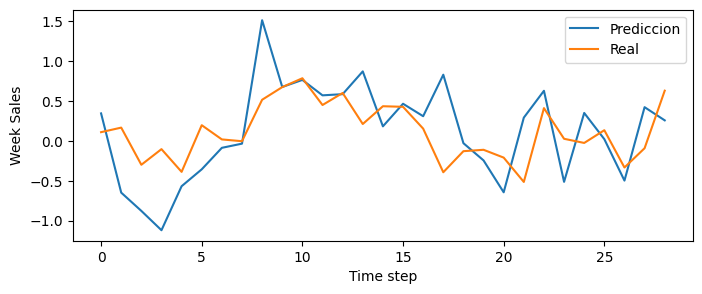

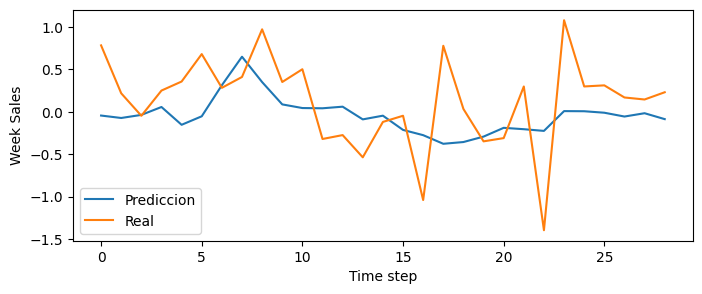

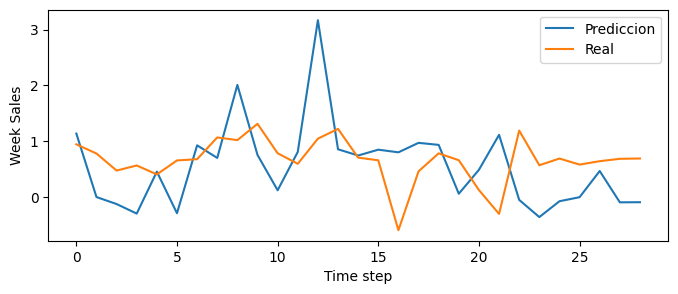

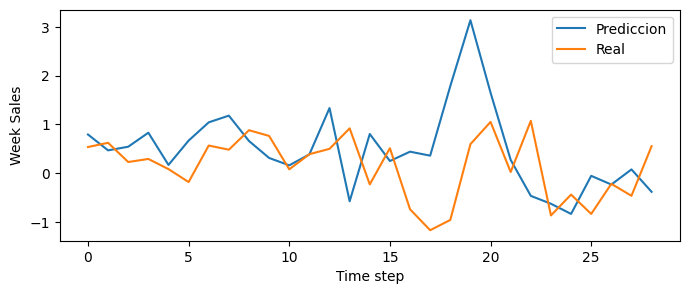

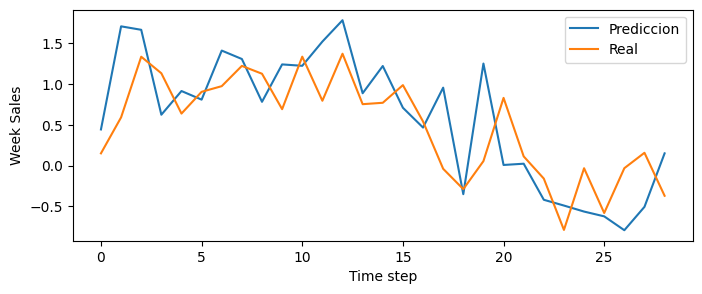

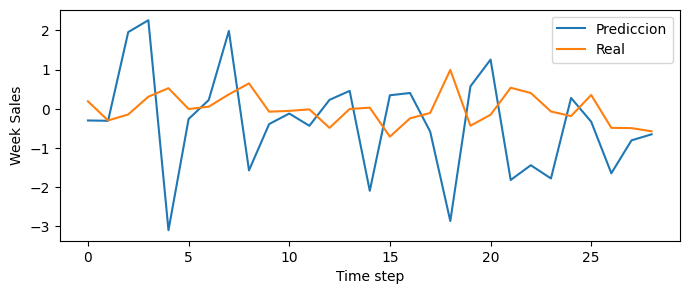

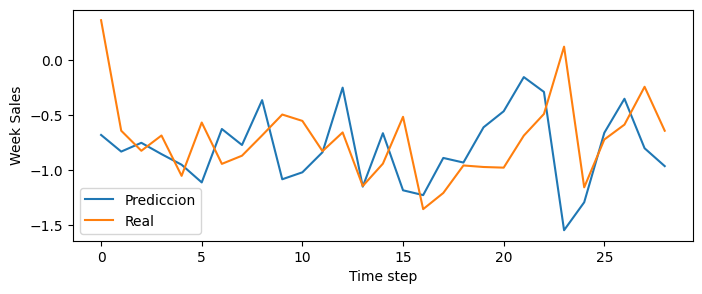

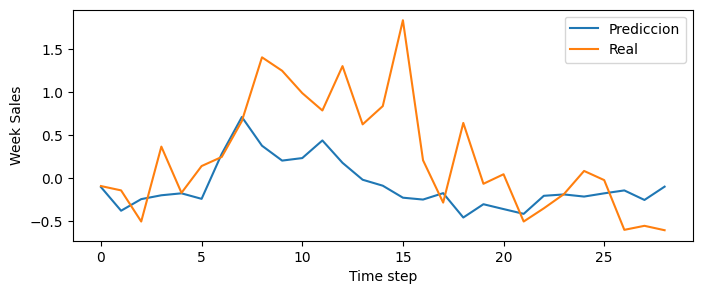

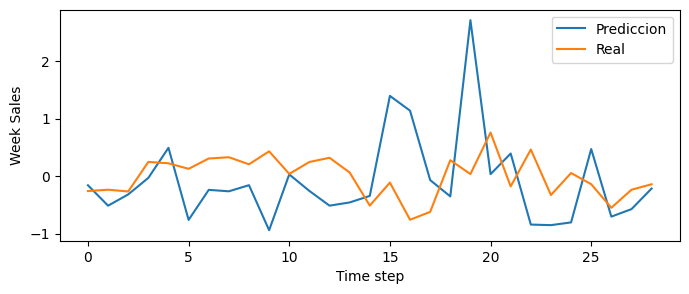

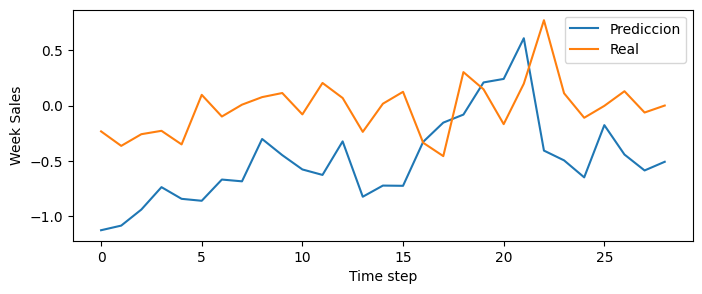

In [152]:
series_result_predict=series_result_predict[0:10]
series_result_real=series_result_real[0:10]
for predict, real in zip(series_result_predict,series_result_real):
  #Grafico de prediccion con el valor real
  tiempo=[x for x in range(predict.shape[0])]
  plt.figure(figsize=(8,3))
  plt.plot(tiempo,real)
  plt.ylabel('Week Sales', size=10)
  plt.plot(tiempo,predict)
  plt.xlabel('Time step', size=10)
  plt.legend(['Prediccion','Real'])
  plt.show()